In [1]:
!pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /private/var/folders/wx/fzmjh7k14k500bnyqlpwchtc0000gp/T/pip-install-po9ures_/polara_9b08abb4f0ac42f4bcdc91117242af76
  Running command git clone -q https://github.com/evfro/polara.git /private/var/folders/wx/fzmjh7k14k500bnyqlpwchtc0000gp/T/pip-install-po9ures_/polara_9b08abb4f0ac42f4bcdc91117242af76
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  branch 'develop' set up to track 'origin/develop'.


# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.autograd import Variable

import polara
from polara import get_movielens_data
from polara.tools.display import print_frames

# Data Preparation

## Download

The data about users' ratings and movies will be downloaded using polara.

In [3]:
# ?get_movielens_data

In [4]:
ratings, genres = get_movielens_data(
    get_genres=True,
    split_genres=False,
    include_time=True
)

ratings.shape

(1000209, 4)

In [5]:
movies = genres
movies.shape

(3883, 3)

The data about users is stored in a separate file as Polara doesn't offer possibility to download user features.

In [6]:
users = pd.read_csv("users.csv")
users.shape

(6040, 5)

## Description

In [7]:
ratings.nunique()

userid         6040
movieid        3706
rating            5
timestamp    458455
dtype: int64

In [8]:
ratings.head()

,userid,movieid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
movies.head()

,movieid,movienm,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
users.head()

,userid,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Text(0.5, 1.0, 'Ratings Distribution')

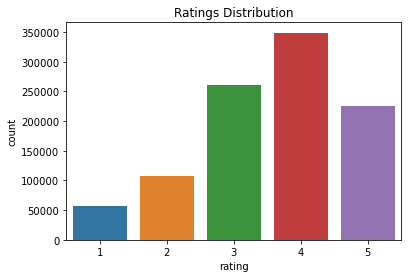

In [11]:
sns.countplot(x = "rating", data = ratings).set_title("Ratings Distribution")

## Preprocessing

### Movie data

Genre splitting

In [12]:
genres = set()

for movie_genres in movies["genres"]:
  for genre in movie_genres.split("|"):
    genres.add(genre)

In [13]:
col = 2
for genre in genres:
  movies.insert(col, genre, np.zeros(len(movies["genres"]), int))
  col += 1

In [14]:
for index, row in movies.iterrows():
  for genre in row["genres"].split("|"):
    movies.loc[index, genre] = 1

movies = movies.drop(["movienm", "genres"], axis = 1)
movies.head()

,movieid,Crime,War,Fantasy,Children's,Thriller,Adventure,Western,Documentary,Film-Noir,Action,Musical,Romance,Sci-Fi,Mystery,Animation,Horror,Drama,Comedy
0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,2,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Ratings data

Done with a reference to [stream data of users preprocessing](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

#### Top-n movies collection

In [15]:
n = 30

top_movies_index = ratings.groupby("movieid").count().sort_values("userid", ascending = False).head(n).reset_index()["movieid"]
top_movies_index.head()

0    2858
1     260
2    1196
3    1210
4     480
Name: movieid, dtype: int64

In [16]:
top_movies = movies[movies.movieid.isin(top_movies_index)]
top_movies.shape

(30, 19)

In [17]:
filtered_ratings_original = ratings[ratings["movieid"].isin(top_movies_index)]
filtered_ratings_original.shape

(73972, 4)

In [18]:
filtered_ratings_original["reward"] = np.where(filtered_ratings_original["rating"] < 5, 0, 1)
filtered_ratings_original.head()

<ipython-input-18-0b212c230073>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ratings_original["reward"] = np.where(filtered_ratings_original["rating"] < 5, 0, 1)


,userid,movieid,rating,timestamp,reward
5,1,1197,3,978302268,0
22,1,1270,5,978300055,1
23,1,527,5,978824195,1
26,1,1097,4,978301953,0
38,1,2762,4,978302091,0


In [19]:
filtered_ratings_original = filtered_ratings_original.reset_index(drop = True)

<AxesSubplot:>

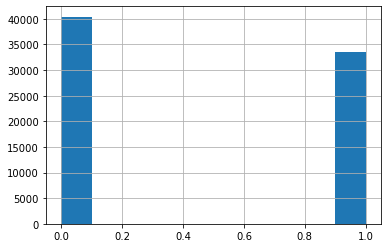

In [20]:
filtered_ratings_original.reward.hist()

In [21]:
reward_mean = filtered_ratings_original.reward.mean()
reward_mean

0.45364462228951496

In [22]:
# Reshuffling rows to randomise it
np.random.seed(42)
filtered_ratings = filtered_ratings_original.reindex(np.random.permutation(filtered_ratings_original.index)).reset_index(drop = True)
filtered_ratings = filtered_ratings_original.reset_index(drop = True)

### User data

Done with a reference to [user data preprocessing](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

In [23]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
names = ['<20', '20-29', '30-39','40-49', '51-60', '60+']

users['agegroup'] = pd.cut(users['age'], bins, labels=names)
users = users.drop(["age"], axis = 1)
users.head()

,userid,gender,occupation,zipcode,agegroup
0,1,F,10,48067,<20
1,2,M,16,70072,51-60
2,3,M,15,55117,20-29
3,4,M,7,02460,40-49
4,5,M,20,55455,20-29


In [24]:
users["occupation"] = users["occupation"].map({
	  0:  "other or not specified",
	  1:  "academic/educator",
	  2:  "artist",
	  3:  "clerical/admin",
	  4:  "college/grad student",
	  5:  "customer service",
	  6:  "doctor/health care",
	  7:  "executive/managerial",
	  8:  "farmer",
	  9:  "homemaker",
	 10:  "K-12 student",
	 11:  "lawyer",
	 12:  "programmer",
	 13:  "retired",
	 14:  "sales/marketing",
	 15:  "scientist",
	 16:  "self-employed",
	 17:  "technician/engineer",
	 18:  "tradesman/craftsman",
	 19:  "unemployed",
	 20:  "writer"})

In [25]:
columnsToEncode = ["agegroup", "gender", "occupation"]
myEncoder = OneHotEncoder(sparse = False, handle_unknown='ignore')
myEncoder.fit(users[columnsToEncode])

users_d = users.drop(columnsToEncode, axis = 1)

users = pd.concat([users_d,
                   pd.DataFrame(myEncoder.transform(users[columnsToEncode]).astype(int),
                   columns = myEncoder.get_feature_names(columnsToEncode))],
                                                         axis=1).reindex()
users = users.drop(["zipcode"], axis = 1)
print(users.shape)
users.head()

(6040, 29)


,userid,agegroup_20-29,agegroup_30-39,agegroup_40-49,agegroup_51-60,agegroup_<20,gender_F,gender_M,occupation_K-12 student,occupation_academic/educator,...,occupation_other or not specified,occupation_programmer,occupation_retired,occupation_sales/marketing,occupation_scientist,occupation_self-employed,occupation_technician/engineer,occupation_tradesman/craftsman,occupation_unemployed,occupation_writer
0,1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# ε-greedy Approach Reaslisation

In [26]:
def receive_history_statistics(history):
    history_statistics = history[["movieid", "reward"]].groupby("movieid").agg({"reward": ["mean"]})
    history_statistics.columns = ["mean"]
    history_statistics["movieid"] = history_statistics.index
    history_statistics = history_statistics.reset_index(drop = True)
    history_statistics = history_statistics.sort_values("mean", ascending = False)
    return history_statistics

In [27]:
def epsilon_greedy_policy(history, epsilon):
    
    # Epsilon likelihood to explore
    exploration = np.random.binomial(1, epsilon)
    
    # Exploration: recommend by random choice
    if exploration == 1 or history.empty == True:
        return np.random.choice(top_movies_index, replace = True)
        
    # Exploitation: recommend with highest rating
    else:
        history_statistics = receive_history_statistics(history)
        return history_statistics.iloc[0]["movieid"]

In [28]:
def ctr_epsilon_greedy_simulator(epsilon, epochs):
    
    np.random.seed(42)
    history = filtered_ratings.iloc[0:0]
    time_steps = 0
    cumulative_rewards = 0
    epsilon_ctr = []
    
    for epoch_iter in range(epochs):
        
        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        
        for i in range(len(ratings)):

            if i % 5000 == 0:
                print("Step " + str(i))
            
            movie_id = ratings.loc[i, "movieid"]
            ratings_reward = ratings.loc[i, "reward"]
            chosen_arm_index = epsilon_greedy_policy(history, epsilon)
            
            if chosen_arm_index == movie_id:
                
                history = history.append(ratings.iloc[i])
                time_steps += 1
                cumulative_rewards += ratings_reward
                epsilon_ctr.append(cumulative_rewards / time_steps)
            
            else:
                
                unused_ratings = unused_ratings.append(ratings.iloc[i])
    
    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": epsilon_ctr}

## ε = 0.3 (exploitation emphasis)

In [67]:
simulation_epsilon_03 = ctr_epsilon_greedy_simulator(epsilon = 0.3, epochs = 3)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 2
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000


In [68]:
# Serializing "simulation_epsilon_03" to a file

with open("simulation_epsilon_03.pkl", "wb") as f:
    pickle.dump(simulation_epsilon_03, f)

In [32]:
with open("pickles//simulation_epsilon_03.pkl", "rb") as f:
    saved_epsilon_03 = pickle.load(f)

In [75]:
saved_epsilon_03 == simulation_epsilon_03

True

Text(0, 0.5, 'CTR')

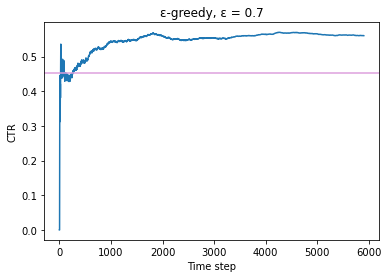

In [33]:
plt.plot(saved_epsilon_03["ctr"])
plt.title("ε-greedy, ε = 0.7")
plt.axhline(y = reward_mean, color = "plum")
plt.xlabel("Time step")
plt.ylabel("CTR")

## ε = 0.7 (exploration emphasis)

In [30]:
simulation_epsilon_07 = ctr_epsilon_greedy_simulator(epsilon = 0.7, epochs = 3)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 2
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000


In [31]:
# Serializing "simulation_epsilon_07" to a file

with open("simulation_epsilon_07.pkl", "wb") as f:
    pickle.dump(simulation_epsilon_07, f)

In [34]:
with open("pickles//simulation_epsilon_07.pkl", "rb") as f:
    saved_epsilon_07 = pickle.load(f)

In [34]:
saved_epsilon_07 == simulation_epsilon_07

True

Text(0, 0.5, 'CTR')

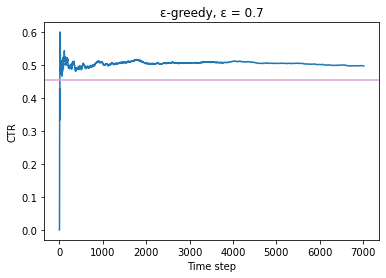

In [35]:
plt.plot(saved_epsilon_07["ctr"])
plt.title("ε-greedy, ε = 0.7")
plt.axhline(y = reward_mean, color = "plum")
plt.xlabel("Time step")
plt.ylabel("CTR")

In [37]:
min_epsilon_time_steps = min(len(saved_epsilon_03["ctr"]), 
                             len(saved_epsilon_07["ctr"]))

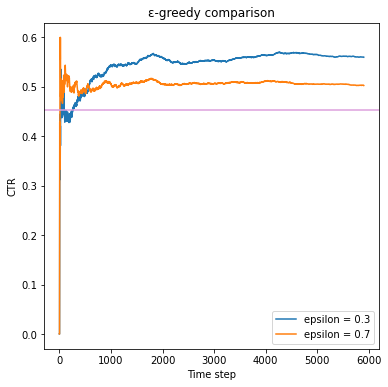

In [38]:
plt.figure(figsize=(6, 6))
plt.plot(saved_epsilon_03["ctr"][: min_epsilon_time_steps], label = "epsilon = 0.3")
plt.plot(saved_epsilon_07["ctr"][: min_epsilon_time_steps], label = "epsilon = 0.7")
plt.axhline(y = reward_mean, color = "plum")
plt.title("ε-greedy comparison")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

# LinUCB Disjoint Approach Realisation

Realisation is referenced from [LinUCB disjoint realisation](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

In [41]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():

    def __init__(self, arm_index, d, alpha):

        self.arm_index = arm_index
        self.alpha = alpha

        # A: (d x d) matrix = D.T * D + I
        self.A = np.identity(d)

        # b: (d x 1) response vector = D.T * c (in ridge regression formulation)
        self.b = np.zeros([d,1])

    def calc_UCB(self, x_array):
        
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)

        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta: (d x 1) dimension vector = A_inv * b
        self.theta = np.dot(A_inv, self.b)

        # UCB: (1 x 1) dimension vector = expected_reward + alpha * std_dev
        expected_reward = np.dot(self.theta.T, x_array)
        std_dev = np.sqrt(np.dot(x_array.T, np.dot(A_inv, x_array)))
        UCB = expected_reward +  self.alpha * std_dev

        return UCB

    def reward_update(self, reward, x_array):
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)

        # Update b which is (d x 1) vector
        self.b += reward * x_array

In [42]:
class linucb_disjoint_policy():

    def __init__(self, K_arms, d, alpha):
        
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]

    def select_arm(self, x_array):
        
        highest_UCB = -1

        # Track index of arms to be selected
        candidate_arms = []

        for arm_index in range(self.K_arms):
            
            # Calculate UCB based on each arm using current covariates at time t
            arm_UCB = self.linucb_arms[arm_index].calc_UCB(x_array)

            # If current arm's UCB is higher than current highest_UCB
            if arm_UCB > highest_UCB:

                # Set new highest_ucb
                highest_UCB = arm_UCB

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_UCB == highest_UCB:

                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly
        chosen_arm = np.random.choice(candidate_arms)

        return chosen_arm

    def store_arm_index(self, arms_index_array):

        # Loop through all arms to store their indices
        for i in range(self.K_arms):

            self.linucb_arms[i].arm_index = arms_index_array[i]

In [43]:
def ctr_disjoint_simulator(K_arms, d, alpha, epochs, top_movies_index, filtered_ratings):
    
    np.random.seed(42)
    
    # Initiate policy
    linucb_disjoint_policy_object = linucb_disjoint_policy(K_arms = K_arms, d = d, alpha = alpha)

    # Store specific arm_index
    linucb_disjoint_policy_object.store_arm_index(top_movies_index.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):
            
            if i % 5000 == 0:
                print("Step " + str(i))

            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x: User features
            users_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            users_x_array = users_x_array.reshape(28, 1)

            ratings_reward = ratings.loc[i, "reward"]

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_disjoint_policy_object.select_arm(users_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            if linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                linucb_disjoint_policy_object.linucb_arms[chosen_arm_index].reward_update(ratings_reward, 
                                                                                          users_x_array)
                
                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy": linucb_disjoint_policy_object}

## LinUCB Disjoint with α = 0.5 (exploitation focus)

In [46]:
alpha_value = 0.5
simulation_disjoint_alpha_05 = ctr_disjoint_simulator(K_arms = n, d = 28,
                                                      alpha = alpha_value, 
                                                      epochs = 3,
                                                      top_movies_index = top_movies_index,
                                                      filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 2
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000


In [52]:
# Serializing "simulation_disjoint_alpha_05" to a file

with open("simulation_disjoint_alpha_05.pkl", "wb") as f:
    pickle.dump(simulation_disjoint_alpha_05, f)

In [44]:
with open("pickles//simulation_disjoint_alpha_05.pkl", "rb") as f:
    saved_disjoint_alpha_05 = pickle.load(f)

Text(0, 0.5, 'CTR')

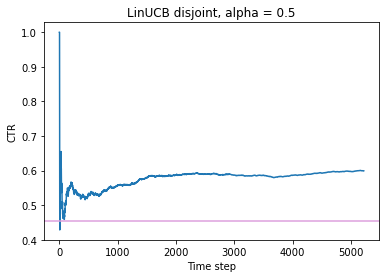

In [45]:
plt.plot(saved_disjoint_alpha_05["ctr"])
plt.axhline(y = reward_mean, color = "plum")
plt.title("LinUCB disjoint, alpha = 0.5")
plt.xlabel("Time step")
plt.ylabel("CTR")

## LinUCB Disjoint with α = 1.5 (exploration focus)

In [55]:
alpha_value = 1.5
simulation_disjoint_alpha_15 = ctr_disjoint_simulator(K_arms = n, d = 28,
                                                      alpha = alpha_value, 
                                                      epochs = 3,
                                                      top_movies_index = top_movies_index,
                                                      filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 2
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000


In [56]:
# Serializing "simulation_disjoint_alpha_15" to a file

with open("simulation_disjoint_alpha_15.pkl", "wb") as f:
    pickle.dump(simulation_disjoint_alpha_15, f)

In [46]:
with open("pickles//simulation_disjoint_alpha_15.pkl", "rb") as f:
    saved_disjoint_alpha_15 = pickle.load(f)

Text(0, 0.5, 'CTR')

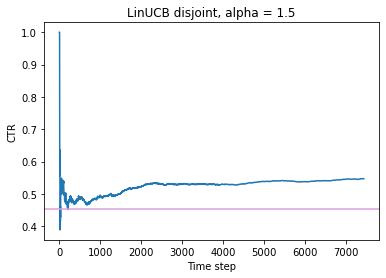

In [47]:
plt.plot(saved_disjoint_alpha_15["ctr"])
plt.axhline(y = reward_mean, color = "plum")
plt.title("LinUCB disjoint, alpha = 1.5")
plt.xlabel("Time step")
plt.ylabel("CTR")

In [48]:
min_disjoint_time_steps = min(len(saved_disjoint_alpha_05["ctr"]), 
                             len(saved_disjoint_alpha_15["ctr"]))

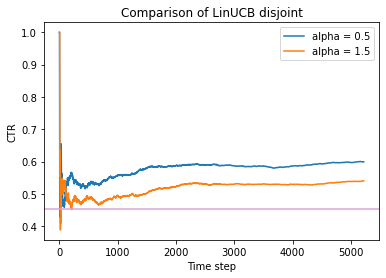

In [49]:
plt.plot(saved_disjoint_alpha_05["ctr"][: min_disjoint_time_steps], 
        label = "alpha = 0.5")
plt.plot(saved_disjoint_alpha_15["ctr"][: min_disjoint_time_steps], 
        label = "alpha = 1.5")
plt.axhline(y = reward_mean, color = "plum")
plt.title("Comparison of LinUCB disjoint")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

In [59]:
min_linucbd_epsilon = min(min_epsilon_time_steps, 
                         min_disjoint_time_steps)

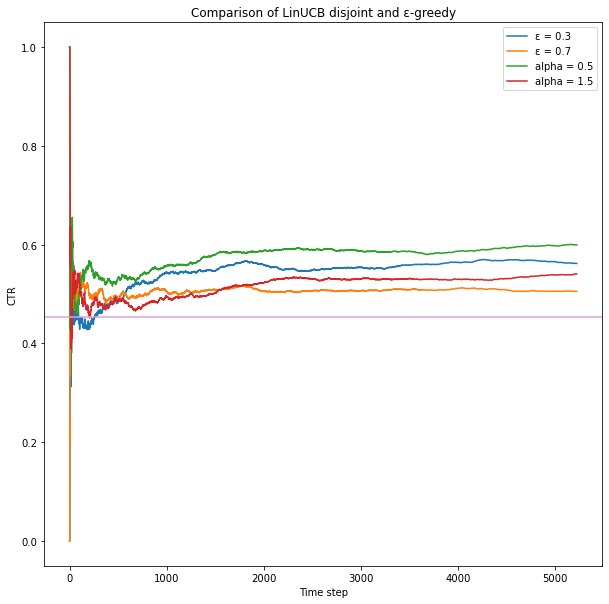

In [66]:
plt.figure(figsize=(10, 10))
plt.plot(saved_epsilon_03["ctr"][: min_linucbd_epsilon], label = "ε = 0.3")
plt.plot(saved_epsilon_07["ctr"][: min_linucbd_epsilon], label = "ε = 0.7")
plt.plot(saved_disjoint_alpha_05["ctr"][: min_linucbd_epsilon], 
        label = "alpha = 0.5")
plt.plot(saved_disjoint_alpha_15["ctr"][: min_linucbd_epsilon], 
        label = "alpha = 1.5")
plt.axhline(y = reward_mean, color = "plum")
plt.title("Comparison of LinUCB disjoint and ε-greedy")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

# LinUCB Hybrid Approach Realisation

Realisation is referenced from [LinUCB hybrid realisation](https://github.com/kfoofw/bandit_simulations/blob/master/python/contextual_bandits/notebooks/LinUCB_hybrid.ipynb).

In [26]:
class linucb_hybrid_arm():
    
    # Shared features coefficients beta_hat are calculated
    # outside of each arm (since they are shared features)

    def __init__(self, d, k, alpha):

        # A: (d * d) matrix = D.T * D + I
        self.A = np.identity(d)

        # B: (d * k) matrix = D.T * c
        self.B = np.zeros([d, k])

        # b: (d * 1) response vector = D.T * c
        self.b = np.zeros([d, 1])

        self.alpha = alpha

    def init_arm_features(self, arm_index, arm_features_array):
        # Track arm_index
        self.index = arm_index

        # arm_features to be used with x_array using outer product
        # to find individual arm z_features
        self.arm_features = arm_features_array


    def calc_UCB(self, x_array, A_node_inv, beta_hat):
        
        # beta_hat is the coefficients for shared features: (k * 1) vector
        # A_node_inv: (k * k) inverse matrix of A_node (shared features)

        # z_array: (k by d) matrix = arm_features * x_array
        z_array = np.outer(self.arm_features, x_array).reshape(-1, 1)

        # Find A inverse for ridge regression (arm-specific)
        A_inv = np.linalg.inv(self.A)

        # theta_arm = A_inv * (b - B * beta_hat)
        self.theta = np.dot(A_inv, (self.b - np.dot(self.B, beta_hat)))

        # std deviation
        pr1 = np.dot(z_array.T, np.dot(A_node_inv, z_array))
        pr2 = np.dot(z_array.T,
                     np.dot(A_node_inv, np.dot(self.B.T,
                                               np.dot(A_inv, x_array))))
        pr3 = np.dot(x_array.T, np.dot(A_inv, x_array))
        pr4 = np.dot(x_array.T,
                     np.dot(A_inv,
                            np.dot(self.B,
                                   np.dot(A_node_inv,
                                          np.dot(self.B.T,
                                                 np.dot(A_inv, x_array))))))

        s = pr1 - 2 * pr2 + pr3 + pr4


        # UCB = z_array.T * beta_hat + x_array.T * theta + alpha * sqrt(std_dev)
        UCB = np.dot(z_array.T, beta_hat) + np.dot(x_array.T, self.theta) \
              + self.alpha * np.sqrt(s)

        return UCB

    def reward_update(self, reward, x_array, z_array):

        # Update A which is (d * d) matrix.
        self.A += np.dot(x_array, x_array.T)

        # Update B which is (d * k) matrix.
        self.B += np.dot(x_array, z_array.T)

        # Update b which is (d * 1) vector
        # reward is scalar
        self.b += reward * x_array

In [27]:
class linucb_hybrid_policy():

    def __init__(self, K_arms, d, k, alpha):
        
        self.K_arms = K_arms
        self.linucb_arms = [linucb_hybrid_arm(d = d, k = k, alpha = alpha) for i in range(K_arms)]

        # shared A_node: (k * k) matrix
        self.A_node = np.identity(k)

        # shared b_node: (k * 1) corresponding response vector.
        self.b_node = np.zeros([k, 1])

    def store_arm_features(self, arms_features_array):

        # Loop through all arms to store the individual arms
        for i in range(self.K_arms):

            self.linucb_arms[i].init_arm_features(arm_index = arms_features_array[i, 0],
                                                  arm_features_array = arms_features_array[i, 1:])

    def select_arm(self, x_array):
        
        highest_UCB = -1

        # Create inverse of A_node
        A_node_inv = np.linalg.inv(self.A_node)


        # beta_hat: (k * 1) vector = A_node_inv * b_node
        beta_hat = np.dot(A_node_inv, self.b_node)

        # Track index of arms to be selected
        candidate_arms = []

        for arm_index in range(self.K_arms):
            
            # Calculate UCB based on each arm using current covariates at time t
            arm_UCB = self.linucb_arms[arm_index].calc_UCB(x_array, A_node_inv, beta_hat)

            if arm_UCB > highest_UCB:

                # Set new highest_UCB
                highest_UCB = arm_UCB

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_UCB == highest_UCB:

                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly
        chosen_arm_index = np.random.choice(candidate_arms)

        return chosen_arm_index

    def update_shared_features_matrices_phase1(self, chosen_arm_B, chosen_arm_A, chosen_arm_b):
        
        # Use chosen arm's B: (d*k), A: (d*d), b: (k*1) for update of shared feature matrices
        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        # A_node = A_node + B.T * A_node_inv * B
        self.A_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        
        # b_node = b_node + B.T * A_node_inv * b
        self.b_node += np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

    def update_shared_features_matrices_phase2(self, z_array, reward, chosen_arm_B, chosen_arm_A, chosen_arm_b):

        chosen_arm_A_inv = np.linalg.inv(chosen_arm_A)
        
        # A_node = A_node + z * z.T - B.T * A_node_inv * B
        self.A_node += np.dot(z_array, z_array.T) - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_B))
        
        # b_node = b_node + reward * z - B.t * A_node_inv * b
        self.b_node += reward * z_array - np.dot(chosen_arm_B.T, np.dot(chosen_arm_A_inv, chosen_arm_b))

In [28]:
def ctr_hybrid_simulator(K_arms, d, k, alpha, epochs, top_movies_index, top_movies, filtered_ratings):
    
    np.random.seed(42)
    
    # Initiate policy
    linucb_hybrid_policy_object = linucb_hybrid_policy(K_arms = K_arms, d = d,
                                                       k = k, alpha = alpha)

    # Store arm specific features
    linucb_hybrid_policy_object.store_arm_features(top_movies.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings dataframe
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        else:
            
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):
            
            if i % 5000 == 0:
                print("step " + str(i))
            
            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x_array: User features
            users_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            users_x_array = users_x_array.reshape(28, 1)

            ratings_reward = ratings.loc[i, "reward"]

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = linucb_hybrid_policy_object.select_arm(users_x_array)


            # Check if arm_index is the same as ratings_arm (ie same actions were chosen)
            if linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].index  == movie_id:


                # Phase 1: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase1(
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                    linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # Extract chosen_arm arm_features to create z_array
                ratings_z_array = np.outer(linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].arm_features, 
                                        users_x_array).reshape(-1,1)

                # Use reward information for the chosen arm to update
                linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].reward_update(ratings_reward, 
                                                                                        users_x_array, 
                                                                                        ratings_z_array)

                # Phase 2: Update shared feature matrices A_node, b_node in policy object
                linucb_hybrid_policy_object.update_shared_features_matrices_phase2(ratings_z_array, ratings_reward,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].B,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].A,
                                                       linucb_hybrid_policy_object.linucb_arms[chosen_arm_index].b)

                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy":linucb_hybrid_policy_object}

## LinUCB Hybrid with α = 0.5 (exploitation focus)

In [29]:
alpha_value = 0.5
simulation_hybrid_alpha_05 = ctr_hybrid_simulator(K_arms = n, d = 28, k = 28 * 18,
                                                  alpha = alpha_value, epochs = 3,
                                                  top_movies_index = top_movies_index, 
                                                  top_movies = top_movies,
                                                  filtered_ratings = filtered_ratings)

Epoch: 0
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000
Epoch: 1
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000
Epoch: 2
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000


In [30]:
# Serializing "simulation_hybrid_alpha_05" to a file

with open("simulation_hybrid_alpha_05.pkl", "wb") as f:
    pickle.dump(simulation_hybrid_alpha_05, f)

In [31]:
with open("pickles//simulation_hybrid_alpha_05.pkl", "rb") as f:
    saved_hybrid_alpha_05 = pickle.load(f)

Text(0, 0.5, 'CTR')

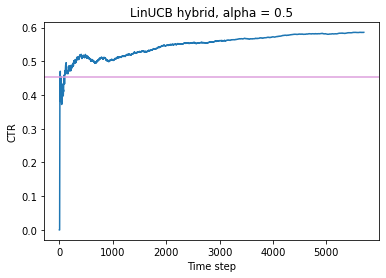

In [52]:
plt.plot(saved_hybrid_alpha_05["ctr"])
plt.axhline(y = reward_mean, color = "plum")
plt.title("LinUCB hybrid, alpha = 0.5")
plt.xlabel("Time step")
plt.ylabel("CTR")

## LinUCB Hybrid with α = 1.5 (exploration focus)

In [53]:
alpha_value = 1.5
simulation_hybrid_alpha_15 = ctr_hybrid_simulator(K_arms = n, d = 28, k = 28 * 18,
                                                  alpha = alpha_value, epochs = 3,
                                                  top_movies_index = top_movies_index, 
                                                  top_movies = top_movies,
                                                  filtered_ratings = filtered_ratings)

Epoch: 0
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000
Epoch: 1
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000
step 70000
Epoch: 2
step 0
step 5000
step 10000
step 15000
step 20000
step 25000
step 30000
step 35000
step 40000
step 45000
step 50000
step 55000
step 60000
step 65000


In [54]:
# Serializing "simulation_hybrid_alpha_15" to a file

with open("simulation_hybrid_alpha_15.pkl", "wb") as f:
    pickle.dump(simulation_hybrid_alpha_15, f)

In [55]:
with open("pickles//simulation_hybrid_alpha_15.pkl", "rb") as f:
    saved_hybrid_alpha_15 = pickle.load(f)

Text(0, 0.5, 'CTR')

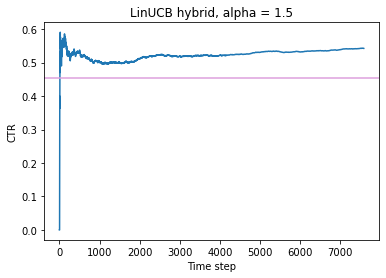

In [56]:
plt.plot(saved_hybrid_alpha_15["ctr"])
plt.axhline(y = reward_mean, color = "plum")
plt.title("LinUCB hybrid, alpha = 1.5")
plt.xlabel("Time step")
plt.ylabel("CTR")

In [57]:
min_hybrid_time_steps = min(len(saved_hybrid_alpha_05["ctr"]), 
                            len(saved_hybrid_alpha_15["ctr"]))

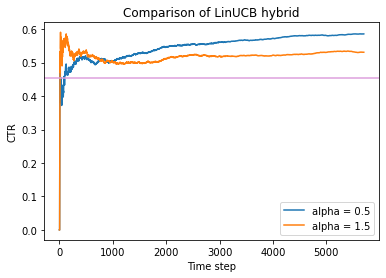

In [58]:
plt.plot(saved_hybrid_alpha_05["ctr"][: min_hybrid_time_steps], 
        label = "alpha = 0.5")
plt.plot(saved_hybrid_alpha_15["ctr"][: min_hybrid_time_steps], 
        label = "alpha = 1.5")
plt.axhline(y = reward_mean, color = "plum")
plt.title("Comparison of LinUCB hybrid")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

In [62]:
min_linucbh_epsilon = min(min_epsilon_time_steps, 
                          min_hybrid_time_steps)

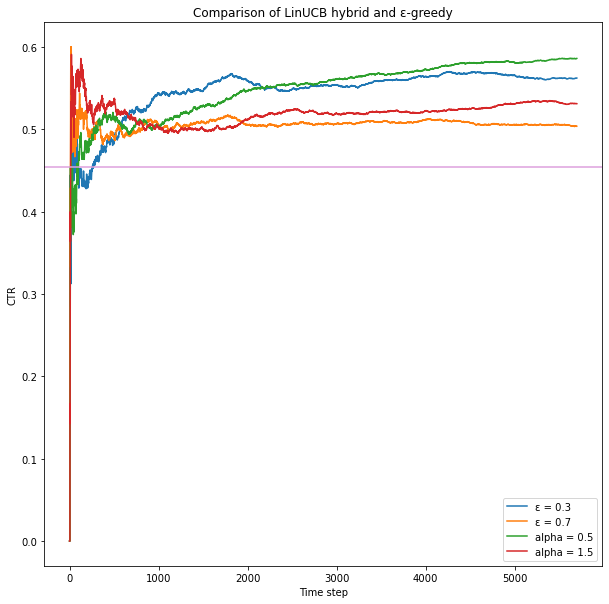

In [67]:
plt.figure(figsize=(10, 10))
plt.plot(saved_epsilon_03["ctr"][: min_linucbh_epsilon], label = "ε = 0.3")
plt.plot(saved_epsilon_07["ctr"][: min_linucbh_epsilon], label = "ε = 0.7")
plt.plot(saved_hybrid_alpha_05["ctr"][: min_linucbh_epsilon], 
        label = "alpha = 0.5")
plt.plot(saved_hybrid_alpha_15["ctr"][: min_linucbh_epsilon], 
        label = "alpha = 1.5")
plt.axhline(y = reward_mean, color = "plum")
plt.title("Comparison of LinUCB hybrid and ε-greedy")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

## Results Comparison between ε-greedy and LinUCB

In [65]:
min_linucb_epsilon_time_steps = min(min_linucbd_epsilon, 
                                    min_linucbh_epsilon)

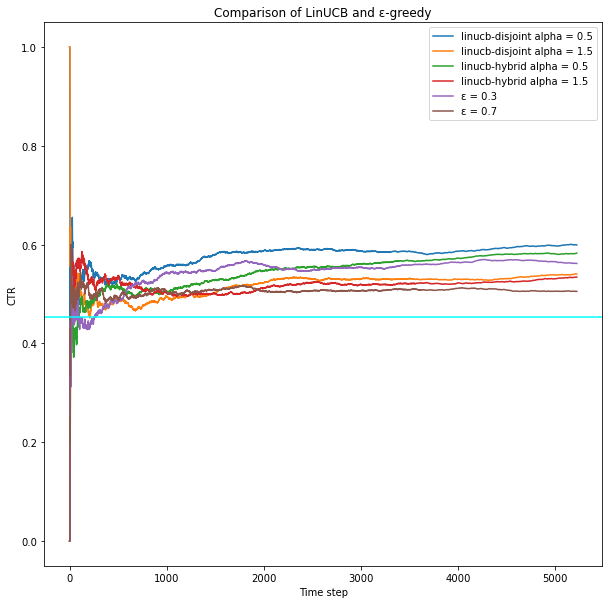

In [68]:
plt.figure(figsize=(10, 10))
plt.plot(saved_disjoint_alpha_05["ctr"][: min_linucb_epsilon_time_steps], 
         label = "linucb-disjoint alpha = 0.5")
plt.plot(saved_disjoint_alpha_15["ctr"][: min_linucb_epsilon_time_steps], 
         label = "linucb-disjoint alpha = 1.5")
plt.plot(saved_hybrid_alpha_05["ctr"][: min_linucb_epsilon_time_steps], 
         label = "linucb-hybrid alpha = 0.5")
plt.plot(saved_hybrid_alpha_15["ctr"][: min_linucb_epsilon_time_steps], 
         label = "linucb-hybrid alpha = 1.5")
plt.plot(saved_epsilon_03["ctr"][: min_linucb_epsilon_time_steps], 
         label = "ε = 0.3")
plt.plot(saved_epsilon_07["ctr"][: min_linucb_epsilon_time_steps], 
         label = "ε = 0.7")
plt.axhline(y=reward_mean, color = "cyan")
plt.title("Comparison of LinUCB and ε-greedy")
plt.xlabel("Time step")
plt.ylabel("CTR")
plt.legend()

# Thompson Sampling for Contextual Bandits

The algorithm for Thomspon Sampling for Contextual Bandits is described at [(Agrawal et al., 2013)](https://proceedings.mlr.press/v28/agrawal13.pdf).

In [26]:
# Create class object for a single Thomspon Sampling contextual arm
class thompson_sampling_contextual_arm():

    def __init__(self, arm_index, d, R, epsilon, delta):

        self.arm_index = arm_index
        
        # mu: (d x 1) matrix
        self.mu = np.zeros([d, 1])

        # B: (d x d) matrix
        self.B = np.identity(d)

        # f: (d x 1) matrix
        self.f = np.zeros([d, 1])
        
        # v: coefficient at the std for mu draw from Gaussian distribution
        self.v = R * np.sqrt(24 / epsilon * d * np.log(1 / delta))

    def draw_mu(self, x_array):
        
        # B_inv: inverse matrix of B
        B_inv = np.linalg.inv(self.B)
        v_sq = self.v * self.v
        
        # Draw mu from Gaussian distribution with parameters mu and v_sq * B_inv
        mu_drawn = np.random.multivariate_normal(self.mu.flat, v_sq * B_inv)
        arm_reward = np.dot(x_array.T, mu_drawn)
        
        return arm_reward

    def reward_update(self, reward, x_array):
        
        # Update B
        self.B += np.dot(x_array, x_array.T)

        # Update f
        self.f += reward * x_array
        
        # Update mu
        B_inv = np.linalg.inv(self.B)
        self.mu = np.dot(B_inv, self.f)

In [40]:
class thompson_sampling_contextual_policy():

    def __init__(self, K_arms, d, R, epsilon, delta): #self, arm_index, mu, d, R, epsilon, delta
        
        self.K_arms = K_arms
        self.tsc_arms = [thompson_sampling_contextual_arm(arm_index = i, 
                                                          d = d, 
                                                          R = R,
                                                          epsilon = epsilon,
                                                          delta = delta) for i in range(K_arms)]

    def select_arm(self, x_array):
        
        highest_reward = -1

        # Track index of arms to be selected
        candidate_arms = []

        for arm_index in range(self.K_arms):
            
            # Calculate UCB based on each arm using current covariates at time t
            arm_reward = self.tsc_arms[arm_index].draw_mu(x_array)

            # If current arm's UCB is higher than current highest_UCB
            if arm_reward > highest_reward:

                # Set new highest_ucb
                highest_reward = arm_reward

                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_reward == highest_reward:

                candidate_arms.append(arm_index)

        # Choose based on candidate_arms randomly
        chosen_arm = np.random.choice(candidate_arms)

        return chosen_arm

    def store_arm_index(self, arms_index_array):

        # Loop through all arms to store their indices
        for i in range(self.K_arms):

            self.tsc_arms[i].arm_index = arms_index_array[i]

In [41]:
def ctr_tsc_simulator(K_arms, d, R, epsilon, delta, epochs, top_movies_index, filtered_ratings):
    
    np.random.seed(42)
    
    # Initiate policy
    thompson_sampling_contextual_object = thompson_sampling_contextual_policy(K_arms = K_arms, 
                                                                              d = d, R = R, 
                                                                              epsilon = epsilon, 
                                                                              delta = delta)

    # Store specific arm_index
    thompson_sampling_contextual_object.store_arm_index(top_movies_index.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):
            
            if i % 5000 == 0:
                print("Step " + str(i))

            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x: User features
            users_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            users_x_array = users_x_array.reshape(28, 1)

            ratings_reward = ratings.loc[i, "reward"]

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = thompson_sampling_contextual_object.select_arm(users_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            if thompson_sampling_contextual_object.tsc_arms[chosen_arm_index].arm_index  == movie_id:

                # Use reward information for the chosen arm to update
                thompson_sampling_contextual_object.tsc_arms[chosen_arm_index].reward_update(ratings_reward, 
                                                                                             users_x_array)
                
                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy": thompson_sampling_contextual_object}

## Thompson Sampling for Contextual Bandits with R = 0.01, ε = 0.2, δ = 0.5

In [42]:
R_value = 0.01
epsilon_value = 0.2
delta_value = 0.5
simulation_thompson_sampling_contextual_eps02 = ctr_tsc_simulator(K_arms = n, d = 28,
                                                                  R = R_value, 
                                                                  epsilon = epsilon_value,
                                                                  delta = delta_value, 
                                                                  epochs = 3,
                                                                  top_movies_index = top_movies_index,
                                                                  filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


Text(0.5, 1.0, 'TSC with R = 0.01, ε = 0.2, δ = 0.5')

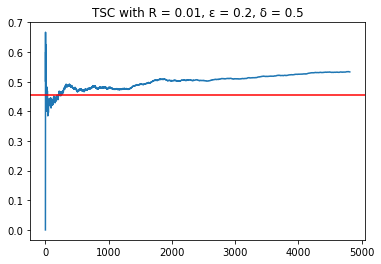

In [48]:
plt.plot(simulation_thompson_sampling_contextual_eps02["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("TSC with R = 0.01, ε = 0.2, δ = 0.5")

## Thompson Sampling for Contextual Bandits with R = 0.1, ε = 0.2, δ = 0.5

In [49]:
R_value = 0.1
epsilon_value = 0.2
delta_value = 0.5
simulation_thompson_sampling_contextual_r01 = ctr_tsc_simulator(K_arms = n, d = 28,
                                                                R = R_value, 
                                                                epsilon = epsilon_value,
                                                                delta = delta_value, 
                                                                epochs = 3,
                                                                top_movies_index = top_movies_index,
                                                                filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


Text(0.5, 1.0, 'TSC with R = 0.1, ε = 0.2, δ = 0.5')

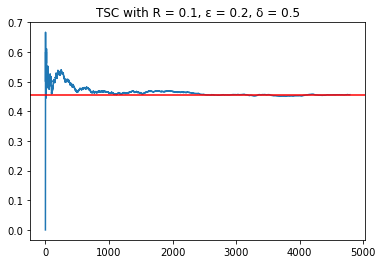

In [50]:
plt.plot(simulation_thompson_sampling_contextual_r01["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("TSC with R = 0.1, ε = 0.2, δ = 0.5")

## Thompson Sampling for Contextual Bandits with R = 0.01, ε = 0.7, δ = 0.5

In [51]:
R_value = 0.01
epsilon_value = 0.7
delta_value = 0.5
simulation_thompson_sampling_contextual_e07 = ctr_tsc_simulator(K_arms = n, d = 28,
                                                                R = R_value, 
                                                                epsilon = epsilon_value,
                                                                delta = delta_value, 
                                                                epochs = 3,
                                                                top_movies_index = top_movies_index,
                                                                filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


Text(0.5, 1.0, 'TSC with R = 0.01, ε = 0.7, δ = 0.5')

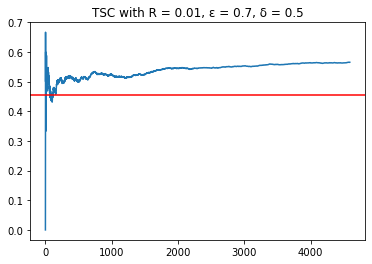

In [52]:
plt.plot(simulation_thompson_sampling_contextual_e07["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("TSC with R = 0.01, ε = 0.7, δ = 0.5")

## Thompson Sampling for Contextual Bandits with R = 0.01, ε = 0.2, δ = 0.1

In [53]:
R_value = 0.01
epsilon_value = 0.2
delta_value = 0.1
simulation_thompson_sampling_contextual_delta01 = ctr_tsc_simulator(K_arms = n, d = 28,
                                                                    R = R_value, 
                                                                    epsilon = epsilon_value,
                                                                    delta = delta_value, 
                                                                    epochs = 3,
                                                                    top_movies_index = top_movies_index,
                                                                    filtered_ratings = filtered_ratings)

Epoch: 0
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Epoch: 1
Step 0
Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000


Text(0.5, 1.0, 'TSC with R = 0.01, ε = 0.2, δ = 0.1')

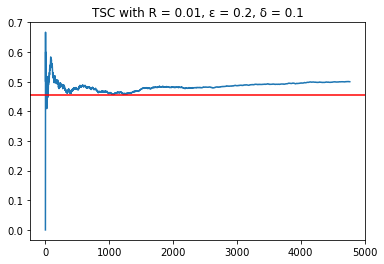

In [54]:
plt.plot(simulation_thompson_sampling_contextual_delta01["ctr"])
plt.axhline(y=reward_mean, color = "red")
plt.title("TSC with R = 0.01, ε = 0.2, δ = 0.1")

## Results Comparison for TSC

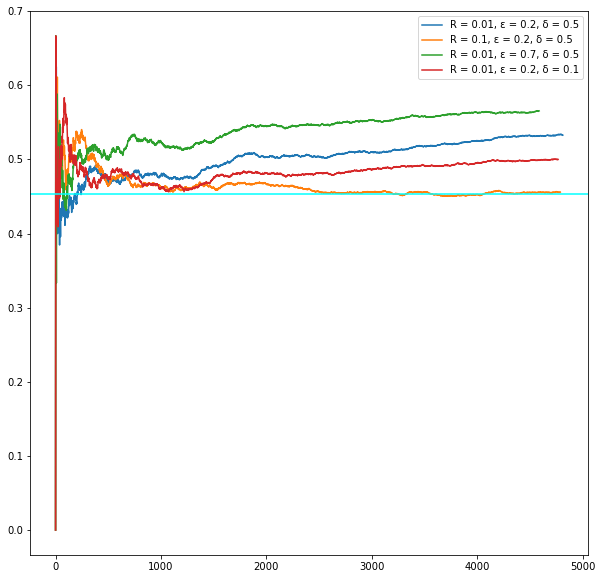

In [61]:
plt.figure(figsize=(10, 10))
plt.plot(simulation_thompson_sampling_contextual_eps02["ctr"], label = "R = 0.01, ε = 0.2, δ = 0.5")
plt.plot(simulation_thompson_sampling_contextual_r01["ctr"], label = "R = 0.1, ε = 0.2, δ = 0.5")
plt.plot(simulation_thompson_sampling_contextual_e07["ctr"], label = "R = 0.01, ε = 0.7, δ = 0.5")
plt.plot(simulation_thompson_sampling_contextual_delta01["ctr"], label = "R = 0.01, ε = 0.2, δ = 0.1")
plt.axhline(y = reward_mean, color = "cyan")
plt.legend()

# Neural Thompson Sampling

The algorithm for Neural Thomspon Sampling is described at [(Zhang, Weitong, et al., 2020)](https://arxiv.org/pdf/2010.00827).

In [121]:
class NeuralTSMean(nn.Module):
    
    def __init__(self, d, m, L):
        
        super().__init__()
        self.d = d
        self.m = m
        self.L = L
        
        self.layers = [nn.Linear(d, m, bias=False), nn.ReLU()]
        
        for i in range (1, self.L - 1):
            
            self.layers.append(nn.Linear(m, m, bias=False))
            self.layers.append(nn.ReLU())
       
        self.layers.append(nn.Linear(m, 1, bias=False))
        self.layers.append(nn.ReLU())
        self.sequential = nn.ModuleList(self.layers)
      
    # theta0 = (vec(W1), ..., vec(WL))
    def init_parameters(self):
        
        for i in range(0, self.L - 1):
            
            # Initialize the weights of nn.Linear(...)
            if i % 2 == 0:
                
                W = torch.Tensor(np.random.multivariate_normal(0, 4 // self.m)).to(device)
                Wi = torch.cat([W, 
                                torch.zeros(self.m, 1).to(device),
                                torch.zeros(self.m, 1).to(device), 
                                W], axis=1)
                self.sequential[i].weight.data = Wi
                 
        w = torch.Tensor(np.random.multivariate_normal(0, 2 // self.m)).to(device)
        print(w)
        WL = torch.cat([torch.transpose(w, 0, 1), -torch.transpose(w, 0, 1)],axis=1)
        self.sequential[-2].weight.data = WL
        
        
    def forward(self, x_array):

        # Pass the input tensor through each of operations
        for layer in self.sequential:
            
            x_array = layer(x_array)
            
        return np.sqrt(self.m)*x

In [113]:
## Flatten a large tuple containing tensors of different sizes
def flatten(tensor):
    
    T = torch.tensor([]).to(device)
    
    for element in tensor:
        
        T = torch.cat([T, element.to(device).flatten()])
        
    return T
    
# Concatenation of all the parameters of a NN
def get_theta(model):
    
    return flatten(model.parameters())

# Loss function of the Neural Thompson Sampling (min L(theta))
def loss_function_nts(estimated_reward, reward, m, regular_param, theta, theta_0):
    
    return 0.5 * torch.sum(torch.square(estimated_reward - reward)) + \
           0.5 * m * regular_param * torch.square(torch.norm(theta - theta_0))

# Make the transformation of the context vectors 
# so that the assumptions of the authors are met
def transform(x):
    return np.vstack([x / (np.sqrt(2) * np.linalg.norm(x)), 
                      x / (np.sqrt(2) * np.linalg.norm(x))]).reshape(-1)

In [114]:
# Create class object for a single Neural Thomspon Sampling arm
class neural_thompson_sampling_arm():

    def __init__(self, arm_index, nu, L, d, m, regular_param, estimator, loss_function_nts):
        
        self.arm_index = arm_index
        self.d = d
        self.regular_param = regular_param
        self.nu = nu
        self.L = L
        self.m = m
        self.grad = 0
        
        self.neural_mean = estimator(self.d, self.m, self.L)
        self.neural_mean.to(device)
        self.neural_mean.init_parameters()
        
        self.num_params = (self.theta_zero).size(0)
        self.U = regular_param * torch.ones(self.num_params).cuda()
        self.theta_zero = get_theta(self.estimator)
        self.optimizer = torch.optim.Adam(self.estimator.parameters(), lr = 0.001)
        self.current_loss = 0
        self.loss_function = loss_function_nts
        self.clear()

    def estimate_reward(self, x_array):
        
        f = self.neural_mean.forward(x_array)
        g = torch.autograd.grad(outputs = f, inputs = self.neural_mean.parameters())
        g = flatten(g).detach()
        self.grad = g
        U_inv = torch.linalg.inv(self.U)
        sigma_squared = (self.regular_param * (1 / self.m) * \
                         torch.matmul(torch.matmul(g.T, U_inv), g)).to(device)
        arm_reward = torch.normal(f, sigma_squared * self.nu ** 2)
        
        return arm_reward

    def reward_update(self):
        
        self.U += torch.matmul(self.grad, self.grad.T) / m

In [115]:
class neural_thompson_sampling_policy():

    def __init__(self, K_arms, nu, L, d, m, regular_param, estimator, loss_function):
        
        self.K_arms = K_arms
        self.nts_arms = [neural_thompson_sampling_arm(arm_index = i, nu = nu, L = L , 
                                                      d = d, m = m,
                                                      regular_param = regular_param,
                                                      estimator = estimator, 
                                                      loss_function_nts = loss_function) for i in range(K_arms)]

    def select_arm(self, x_array):
        
        estimated_rewards=[]

        for arm_index in range(self.K_arms):
            
            estimated_reward = self.nts_arms[arm_index].estimate_reward()
            estimated_rewards.append(estimated_reward.detach().item())

        # Choose the arm which gets highest expected reward
        chosen_arm = np.argmax(estimated_rewards)

        return chosen_arm

    def store_arm_index(self, arms_index_array):

        # Loop through all arms to store their indices
        for i in range(self.K_arms):

            self.nts_arms[i].arm_index = arms_index_array[i]

In [116]:
def ctr_nts_simulator(K_arms, d, nu, L, m, regular_param, estimator, loss_function):
    
    np.random.seed(42)
    
    # Initiate policy
    neural_ts_object = neural_thompson_sampling_policy(K_arms = K_arms, nu = nu, L = L, 
                                                       d = d, m = m, regular_param = regular_param,
                                                       estimator = estimator, loss_function = loss_function)

    # Store specific arm_index
    neural_ts_object.store_arm_index(top_movies_index.to_numpy())

    # Instantiate trackers
    time_steps = 0
    cumulative_rewards = 0
    ctr = []

    for epoch_iter in range(epochs):

        print("Epoch: " + str(epoch_iter))

        if epoch_iter == 0:
            
            # Start with filtered ratings first
            ratings = filtered_ratings.copy()
            
            # Initiate unused_ratings
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])
        else:
            # Recycle unused data
            ratings = unused_ratings.copy().reset_index(drop = True)
            unused_ratings = pd.DataFrame(columns = ["userid", "movieid", "rating",
                                                     "timestamp", "reward"])

        for i in range(len(ratings)):
            
            if i % 5000 == 0:
                print("Step " + str(i))

            user_id = ratings.loc[i, "userid"]
            movie_id = ratings.loc[i, "movieid"]

            # x: User features
            users_x_array = np.array(users.query("userid == @user_id").drop("userid", 
                                                                              axis = 1))
            
            # Reshape vector from (1, 28) to (28, 1) for calculation purposes
            users_x_array = users_x_array.reshape(28, 1)
            users_x_array = torch.Tensor(users_x_array)

            ratings_reward = ratings.loc[i, "reward"]

            # Find policy's chosen arm based on input covariates at current time step
            chosen_arm_index = neural_ts_object.select_arm(users_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            if neural_ts_object.nts_arms[chosen_arm_index].arm_index == movie_id:

                # Use reward information for the chosen arm to update
                neural_ts_object.nts_arms[chosen_arm_index].reward_update()
                
                # For CTR calculation
                time_steps += 1
                cumulative_rewards += ratings_reward
                ctr.append(cumulative_rewards / time_steps)

            else:
                
                # Recycle data
                unused_ratings = unused_ratings.append(ratings.iloc[i])

    return {"time_steps": time_steps,
            "cumulative_rewards": cumulative_rewards,
            "ctr": ctr,
            "policy": neural_ts_object}

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [122]:
m = 20
simulation_neural_thompson_sampling_m20 = ctr_nts_simulator(K_arms = n, d = 28, nu = 1,
                                                            L = 3, m = m, 
                                                            regular_param = 1.5,
                                                            estimator = NeuralTSMean,
                                                            loss_function = loss_function_nts)

ValueError: mean must be 1 dimensional